In [120]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = (10, 5)
import seaborn as sns
sns.set_style('darkgrid')

# MNIST Dataset

In [3]:
mnist = fetch_openml('mnist_784', version=1)

In [4]:
X, y = mnist['data'], mnist['target']

In [5]:
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

## Split Dataset

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Classifiers

We will start with a simple classifier and move to more complex ones

In [15]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

## Binary Classifier

### Setting Up the Classifier

In [8]:
from sklearn.linear_model import SGDClassifier

In [18]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [50]:
single_sample = X_train.iloc[0].values.reshape(1, -1)

In [51]:
sgd_clf.predict(single_sample)

array([ True])

In [54]:
y_test_5

60000    False
60001    False
60002    False
60003    False
60004    False
         ...  
69995    False
69996    False
69997    False
69998     True
69999    False
Name: class, Length: 10000, dtype: bool

In [69]:
for index in [998, 999]:
    single_sample = X_test.iloc[index].values.reshape(1, -1)
    print(sgd_clf.predict(single_sample))

[False]
[False]


### Evaluating the Classifier

In [78]:
from sklearn.model_selection import cross_val_score

In [80]:
cross_val_score(sgd_clf, X_train, y_train, cv=5, scoring='accuracy')

array([0.88083333, 0.88325   , 0.88116667, 0.86625   , 0.8875    ])

### Creating a Confusion Matrix

In [83]:
from sklearn.model_selection import cross_val_predict


In [84]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [85]:
from sklearn.metrics import confusion_matrix

In [86]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [92]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [97]:
print("Precision: ", np.round(precision_score(y_train_5, y_train_pred),2))
print("Recall: ", np.round(recall_score(y_train_5, y_train_pred),2))
print("F1-score: ", np.round(f1_score(y_train_5, y_train_pred),2))

Precision:  0.84
Recall:  0.65
F1-score:  0.73


In [112]:
single_sample = X_test.iloc[999].values.reshape(1, -1)

In [113]:
sgd_clf.decision_function(single_sample)

array([-5838.15108052])

### Threshold Curve

In [114]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, 
                            method='decision_function')

In [115]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Text(0.5, 0, 'Threshold')

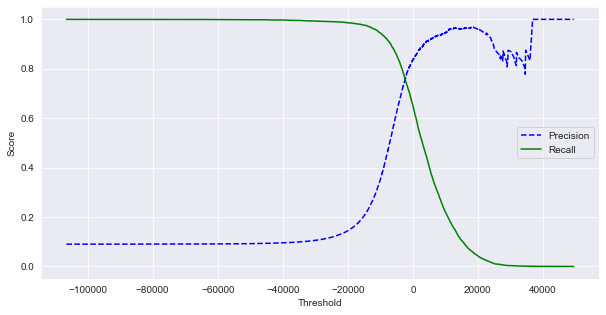

In [122]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.legend()
plt.ylabel('Score')
plt.xlabel('Threshold')

### Precision Recall Curve

Text(0.5, 0, 'Recall')

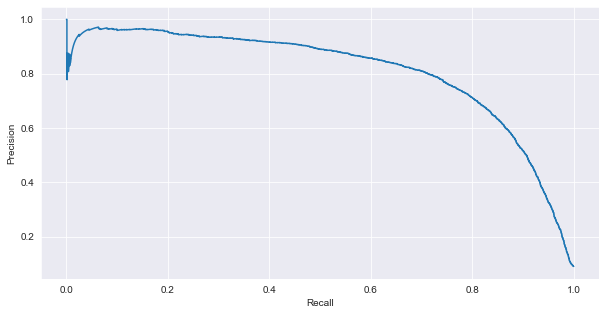

In [125]:
plt.plot(recalls, precisions)
plt.ylabel('Precision')
plt.xlabel('Recall')

### ROC Curve

In [126]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Text(0, 0.5, 'True Positive Rate')

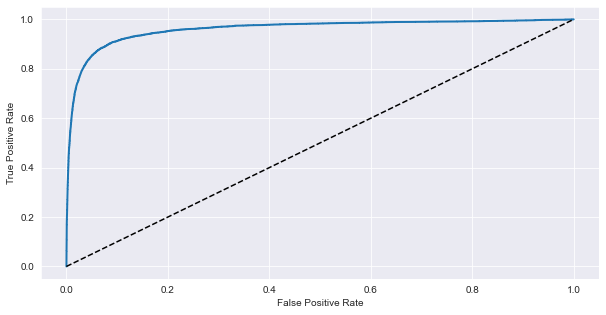

In [127]:
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1],[0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

### AUC

In [128]:
from sklearn.metrics import roc_auc_score

In [131]:
auc_score = roc_auc_score(y_train_5, y_scores)
print(np.round(auc_score, 2))

0.96


### Random Forest Classifier

In [132]:
from sklearn.ensemble import RandomForestClassifier

In [133]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method='predict_proba')

In [134]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

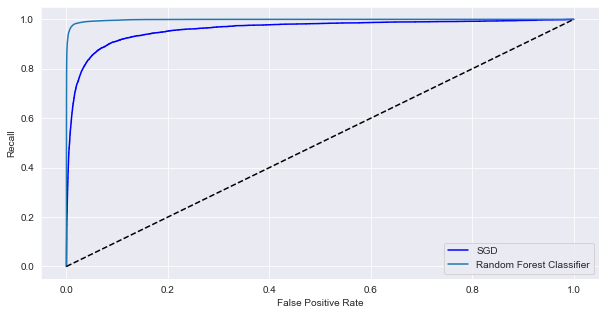

In [136]:
plt.plot(fpr, tpr, 'b', label='SGD')
plt.plot(fpr_forest, tpr_forest, label='Random Forest Classifier')
plt.plot([0,1],[0,1], 'k--')
plt.ylabel('Recall')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')

In [138]:
auc_score_sgd = roc_auc_score(y_train_5, y_scores)
auc_score_rfc = roc_auc_score(y_train_5, y_scores_forest)

In [141]:
for score in [auc_score_sgd, auc_score_rfc]:
    print(np.round(score,3))

0.96
0.998


### Error Analysis

In [144]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)

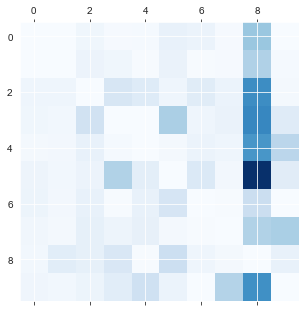

In [148]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.Blues)